# Persistence Landscapes

Persistence Landscapes were first introduced in [Bubenik, 2015](https://www.jmlr.org/papers/volume16/bubenik15a/bubenik15a.pdf). Persistence landscapes were one of the first vectorization schemes introduced for persistence diagrams.

There are two implementations of persistence landscapes in persim. The first is `PersLandscapeExact` class, which treats the persistence landscape exactly as it is defined--namely, there are no approximations. In this implementation, the landscape functions are stored internally as lists of their critical points (the breaks in the piecewise linear functions). The second is the `PersLandscapeApprox` class, which instead samples the landscape functions on a grid which the user can specify. This immediately vectorizes the landscape functions so they can be manipulated, averaged, and then quickly passed into other machine learning algorithms.

Depending on the problem at hand, you can choose either class to perform calculations. **PersLandscapeApprox tends to be much faster than PersLandscapeExact, at the expense of approximate versus exact outputs.** There are methods to convert exact landscapes to approximate ones as well, described below.

## Exact landscapes with `PersLandscapeExact`

In [1]:
import numpy as np
from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple

Let's start with a toy persistence diagram to explore exact landscapes.

In [2]:
pd = [np.array([[0,3], [1,4]]), np.array([[1,4]])]

This diagram has two features in degree 0 and one feature in degree 1 (as output by a `ripser.py` calculation for example). We specify which degree of homology we calculate the landscape in.

In [3]:
ple = PersLandscapeExact(dgms=pd,hom_deg=0)
ple

Exact persistence landscape in homological degree 0

The critical pairs which define the landscapes are stored internally as a list of lists in the `critical_pairs` attribute:

In [4]:
ple.critical_pairs

[[[0, 0], [1.5, 1.5], [2.0, 1.0], [2.5, 1.5], [4, 0]],
 [[1, 0], [2.0, 1.0], [3, 0]]]

This list of lists is "outer indexed" by the depth of the landscape function. Equivalently, `ple.critical_points[i]` provides a list of the critical points of the `i`-th persistence landscape in degree 0. We can see what these pairs of numbers correspond to by plotting the landscape with `plot_landscape_simple`.

<AxesSubplot:>

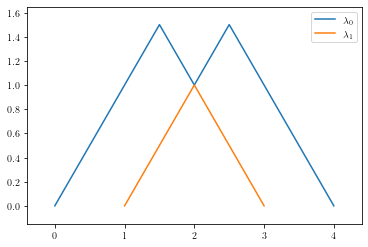

In [5]:
plot_landscape_simple(ple)

### Arithmetic

Basic arithmetic operations are implemented using the traditional `+`, `-`, and `*` operations. 

In [6]:
pd2 = [ np.array([[0.5,7],[3,5],[4.1,6.5]]), np.array([[1,4]])]
ple2 = PersLandscapeExact(dgms=pd2,hom_deg=0)
ple2

Exact persistence landscape in homological degree 0

In [7]:
pl_sum = ple + ple2
pl_sum.critical_pairs

[[[0, 0],
  [0.5, 0.5],
  [1.5, 2.5],
  [2.0, 2.5],
  [2.5, 3.5],
  [3.75, 3.5],
  [4, 3.0],
  [7.0, 0.0]],
 [[1, 0],
  [2.0, 1.0],
  [3, 0.0],
  [4.0, 1.0],
  [4.55, 0.4500000000000002],
  [5.3, 1.2000000000000002],
  [6.5, 0.0]],
 [[4.1, 0], [4.55, 0.4500000000000002], [5.0, 0]]]

In [8]:
(ple - ple2).critical_pairs

[[[0, 0],
  [0.5, 0.5],
  [1.5, 0.5],
  [2.0, -0.5],
  [2.5, -0.5],
  [3.75, -3.0],
  [4, -3.0],
  [7.0, 0.0]],
 [[1, 0],
  [2.0, 1.0],
  [3, 0.0],
  [4.0, -1.0],
  [4.55, -0.4500000000000002],
  [5.3, -1.2000000000000002],
  [6.5, 0.0]],
 [[4.1, 0], [4.55, -0.4500000000000002], [5.0, 0]]]

In [9]:
(7*ple).critical_pairs

[[(0, 0), (1.5, 10.5), (2.0, 7.0), (2.5, 10.5), (4, 0)],
 [(1, 0), (2.0, 7.0), (3, 0)]]

### Slicing and indexing

Landscapes are sliced by depth.

In [10]:
ple[0]

[[0, 0], [1.5, 1.5], [2.0, 1.0], [2.5, 1.5], [4, 0]]

In [11]:
ple[1:]

[[[1, 0], [2.0, 1.0], [3, 0]]]

The standard `p` norms are implemented for all `p`, as well as the supremum norm.

In [12]:
ple.p_norm(p=2)

2.1213203435596424

In [13]:
ple.sup_norm()

1.5

## Approximate landscapes with `PersLandscapeApprox`

Let's use the same persistence diagram as above to explore this class and compare it to the exact landscape counterpart.

In [14]:
from persim import PersLandscapeApprox

In [15]:
pla = PersLandscapeApprox(dgms=pd,hom_deg=0)
pla

Approximate persistence landscape in homological degree 0 on grid from 0 to 4 with 500 steps

The approximate class "snaps" the landscape functions onto a grid. The user can specify the grid manually or (as we just did) can leave it unspecified and an optimal grid will be determined. To specify a grid manually, pass `start`, `stop`, and `num_steps` into the constructor.

In [16]:
pla_manual_grid = PersLandscapeApprox(dgms=pd, hom_deg=0, start=-1, stop=5, num_steps=10000)
pla_manual_grid

Approximate persistence landscape in homological degree 0 on grid from -1 to 5 with 10000 steps

The values interpolated onto the grid are stored in the `values` attribute.

In [17]:
print(pla_manual_grid.values.shape)
print(pla_manual_grid.values)

(2, 10000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Arithmetic

Basic arithmetic operations are also implemented using `+`, `-`, and `*`.

**Note:** Before any arithmetic operations can be carried out, the two approximate landscape classes must be coerced with the same grid parameters. The `snap_PL` function is provided to take of the snapping.

In [18]:
from persim.landscapes import snap_pl

[snapped_pla, snapped_pla_manual_grid] = snap_pl([pla,pla_manual_grid])

In [19]:
print(snapped_pla + 4*snapped_pla_manual_grid)

Approximate persistence landscape in homological degree 0 on grid from -1 to 5 with 10000 steps


Once snapped, all arithmetic operations work as expected.

### Slicing and Indexing

Slicing and Indexing work as with exact landscapes. Here are the 500 sampled values from the depth 0 landscape in `pla`. 

In [20]:
pla[0]

array([0.        , 0.00801603, 0.01603206, 0.0240481 , 0.03206413,
       0.04008016, 0.04809619, 0.05611222, 0.06412826, 0.07214429,
       0.08016032, 0.08817635, 0.09619238, 0.10420842, 0.11222445,
       0.12024048, 0.12825651, 0.13627255, 0.14428858, 0.15230461,
       0.16032064, 0.16833667, 0.17635271, 0.18436874, 0.19238477,
       0.2004008 , 0.20841683, 0.21643287, 0.2244489 , 0.23246493,
       0.24048096, 0.24849699, 0.25651303, 0.26452906, 0.27254509,
       0.28056112, 0.28857715, 0.29659319, 0.30460922, 0.31262525,
       0.32064128, 0.32865731, 0.33667335, 0.34468938, 0.35270541,
       0.36072144, 0.36873747, 0.37675351, 0.38476954, 0.39278557,
       0.4008016 , 0.40881764, 0.41683367, 0.4248497 , 0.43286573,
       0.44088176, 0.4488978 , 0.45691383, 0.46492986, 0.47294589,
       0.48096192, 0.48897796, 0.49699399, 0.50501002, 0.51302605,
       0.52104208, 0.52905812, 0.53707415, 0.54509018, 0.55310621,
       0.56112224, 0.56913828, 0.57715431, 0.58517034, 0.59318

## Other tools for landscapes

Several auxiliary functions have been implemented to facilitate easier analysis with persistence landscapes.

### Death vector

For Vietoris-Rips, Cech, or similar filtrations, the birth times in homological degree 0 are not helpful for distinguishing phenomena. For this case in particular, we provide a calculation of the death vector. The death vector is the vector of death times of features in homological degree 0.

In [21]:
from persim.landscapes import death_vector

In [22]:
dv = death_vector(dgms=pd)
dv

[4, 3]

### Linear Combinations

We provide methods for efficiently computing linear combinations of persistence landscapes, and in particular, computing averages of a large list of landscapes. These methods will automatically snap the landscapes to a common grid if necessary.

In [23]:
from persim.landscapes import average_approx, lc_approx

lc_landscape = lc_approx(landscapes=[pla,2*pla,5*pla], coeffs = [1,1/2,1/5])
np.testing.assert_almost_equal(lc_landscape[0],pla[0]*3)

The above provides a simple example verifying the desired behavior. Here we show an even simpler example with taking an average.

In [24]:
avg_landscape = average_approx([pla,pla,pla,pla])
np.testing.assert_almost_equal(avg_landscape[0],pla[0])

## Visualizations

Simple 2-dimensional and more visually complex 3-dimensional landscape functions can be plotted.

In [25]:
from persim.landscapes import plot_landscape, plot_landscape_simple

The `plot_landscape` method provides a 3-dimensional visualization of the landscape function. This version is computationally expensive to compute, so a lighter, 2-dimensional version is also provided in `plot_landscape_simple`.

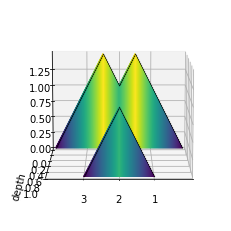

In [26]:
fig = plot_landscape(pla)

<AxesSubplot:>

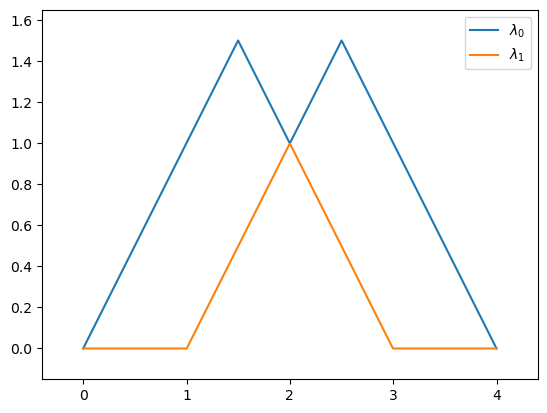

In [27]:
plot_landscape_simple(pla)

Here's one final example to show how all of these methods can be combined. We construct a list of 100 "random" persistence diagrams each with 500 points, their average landscape, and plot it.

In [28]:
from numpy.random import default_rng

rng = default_rng(seed=42)

random_pds = [
    [
        np.array([
        [rng.random(), rng.random()+1] for _ in range(500)
        ])
    ] # extra bracketing to mimic the output of ripser.py
 for _ in range(100)]

In [29]:
pls = [PersLandscapeApprox(dgms=dgm, hom_deg=0) for dgm in random_pds]

avg_pl = average_approx(pls)

The plotting methods return matplot figures (or axes objects) for further user modification if necessary. For example, if we plot `avg_pl`, we will have way too many legend entries, so we can remove those before plotting using standard matplotlib techniques.

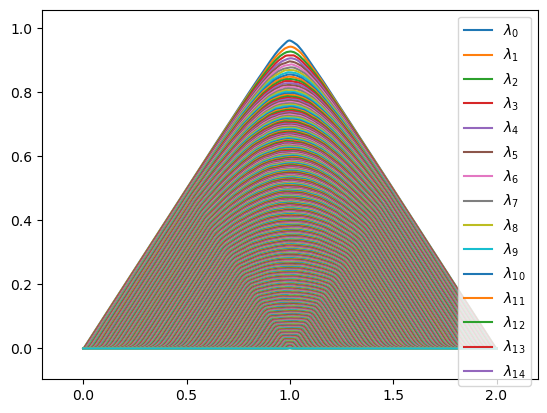

In [30]:
ax = plot_landscape_simple(avg_pl)
my_handles, my_labels = ax.get_legend_handles_labels()
ax.legend(handles=my_handles[:15])